<a href="https://colab.research.google.com/github/ak3ra/stash/blob/main/eBird_update_beta_dists.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import json
import os
import numpy as np
import pickle
from scipy.stats import beta as beta_dist
import matplotlib.pyplot as plt

In [ ]:
!wget https://transfer.sh/fkteMjSgtF/groundtruths_dict.pkl
!wget https://transfer.sh/VEEuURpW3p/preds_dict.pkl

--2023-06-28 17:59:01--  https://transfer.sh/fkteMjSgtF/groundtruths_dict.pkl
Resolving transfer.sh (transfer.sh)... 144.76.136.153, 2a01:4f8:200:1097::2
Connecting to transfer.sh (transfer.sh)|144.76.136.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46446013 (44M) []
Saving to: ‘groundtruths_dict.pkl’

groundtruths_dict.p 100%[===================>]  44.29M  21.3MB/s    in 2.1s    

2023-06-28 17:59:04 (21.3 MB/s) - ‘groundtruths_dict.pkl’ saved [46446013/46446013]

--2023-06-28 17:59:04--  https://transfer.sh/VEEuURpW3p/preds_dict.pkl
Resolving transfer.sh (transfer.sh)... 144.76.136.153, 2a01:4f8:200:1097::2
Connecting to transfer.sh (transfer.sh)|144.76.136.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4649663 (4.4M) []
Saving to: ‘preds_dict.pkl’

preds_dict.pkl      100%[===================>]   4.43M  5.91MB/s    in 0.7s    

2023-06-28 17:59:05 (5.91 MB/s) - ‘preds_dict.pkl’ saved [4649663/4649663]



![image](Screenshot.png)
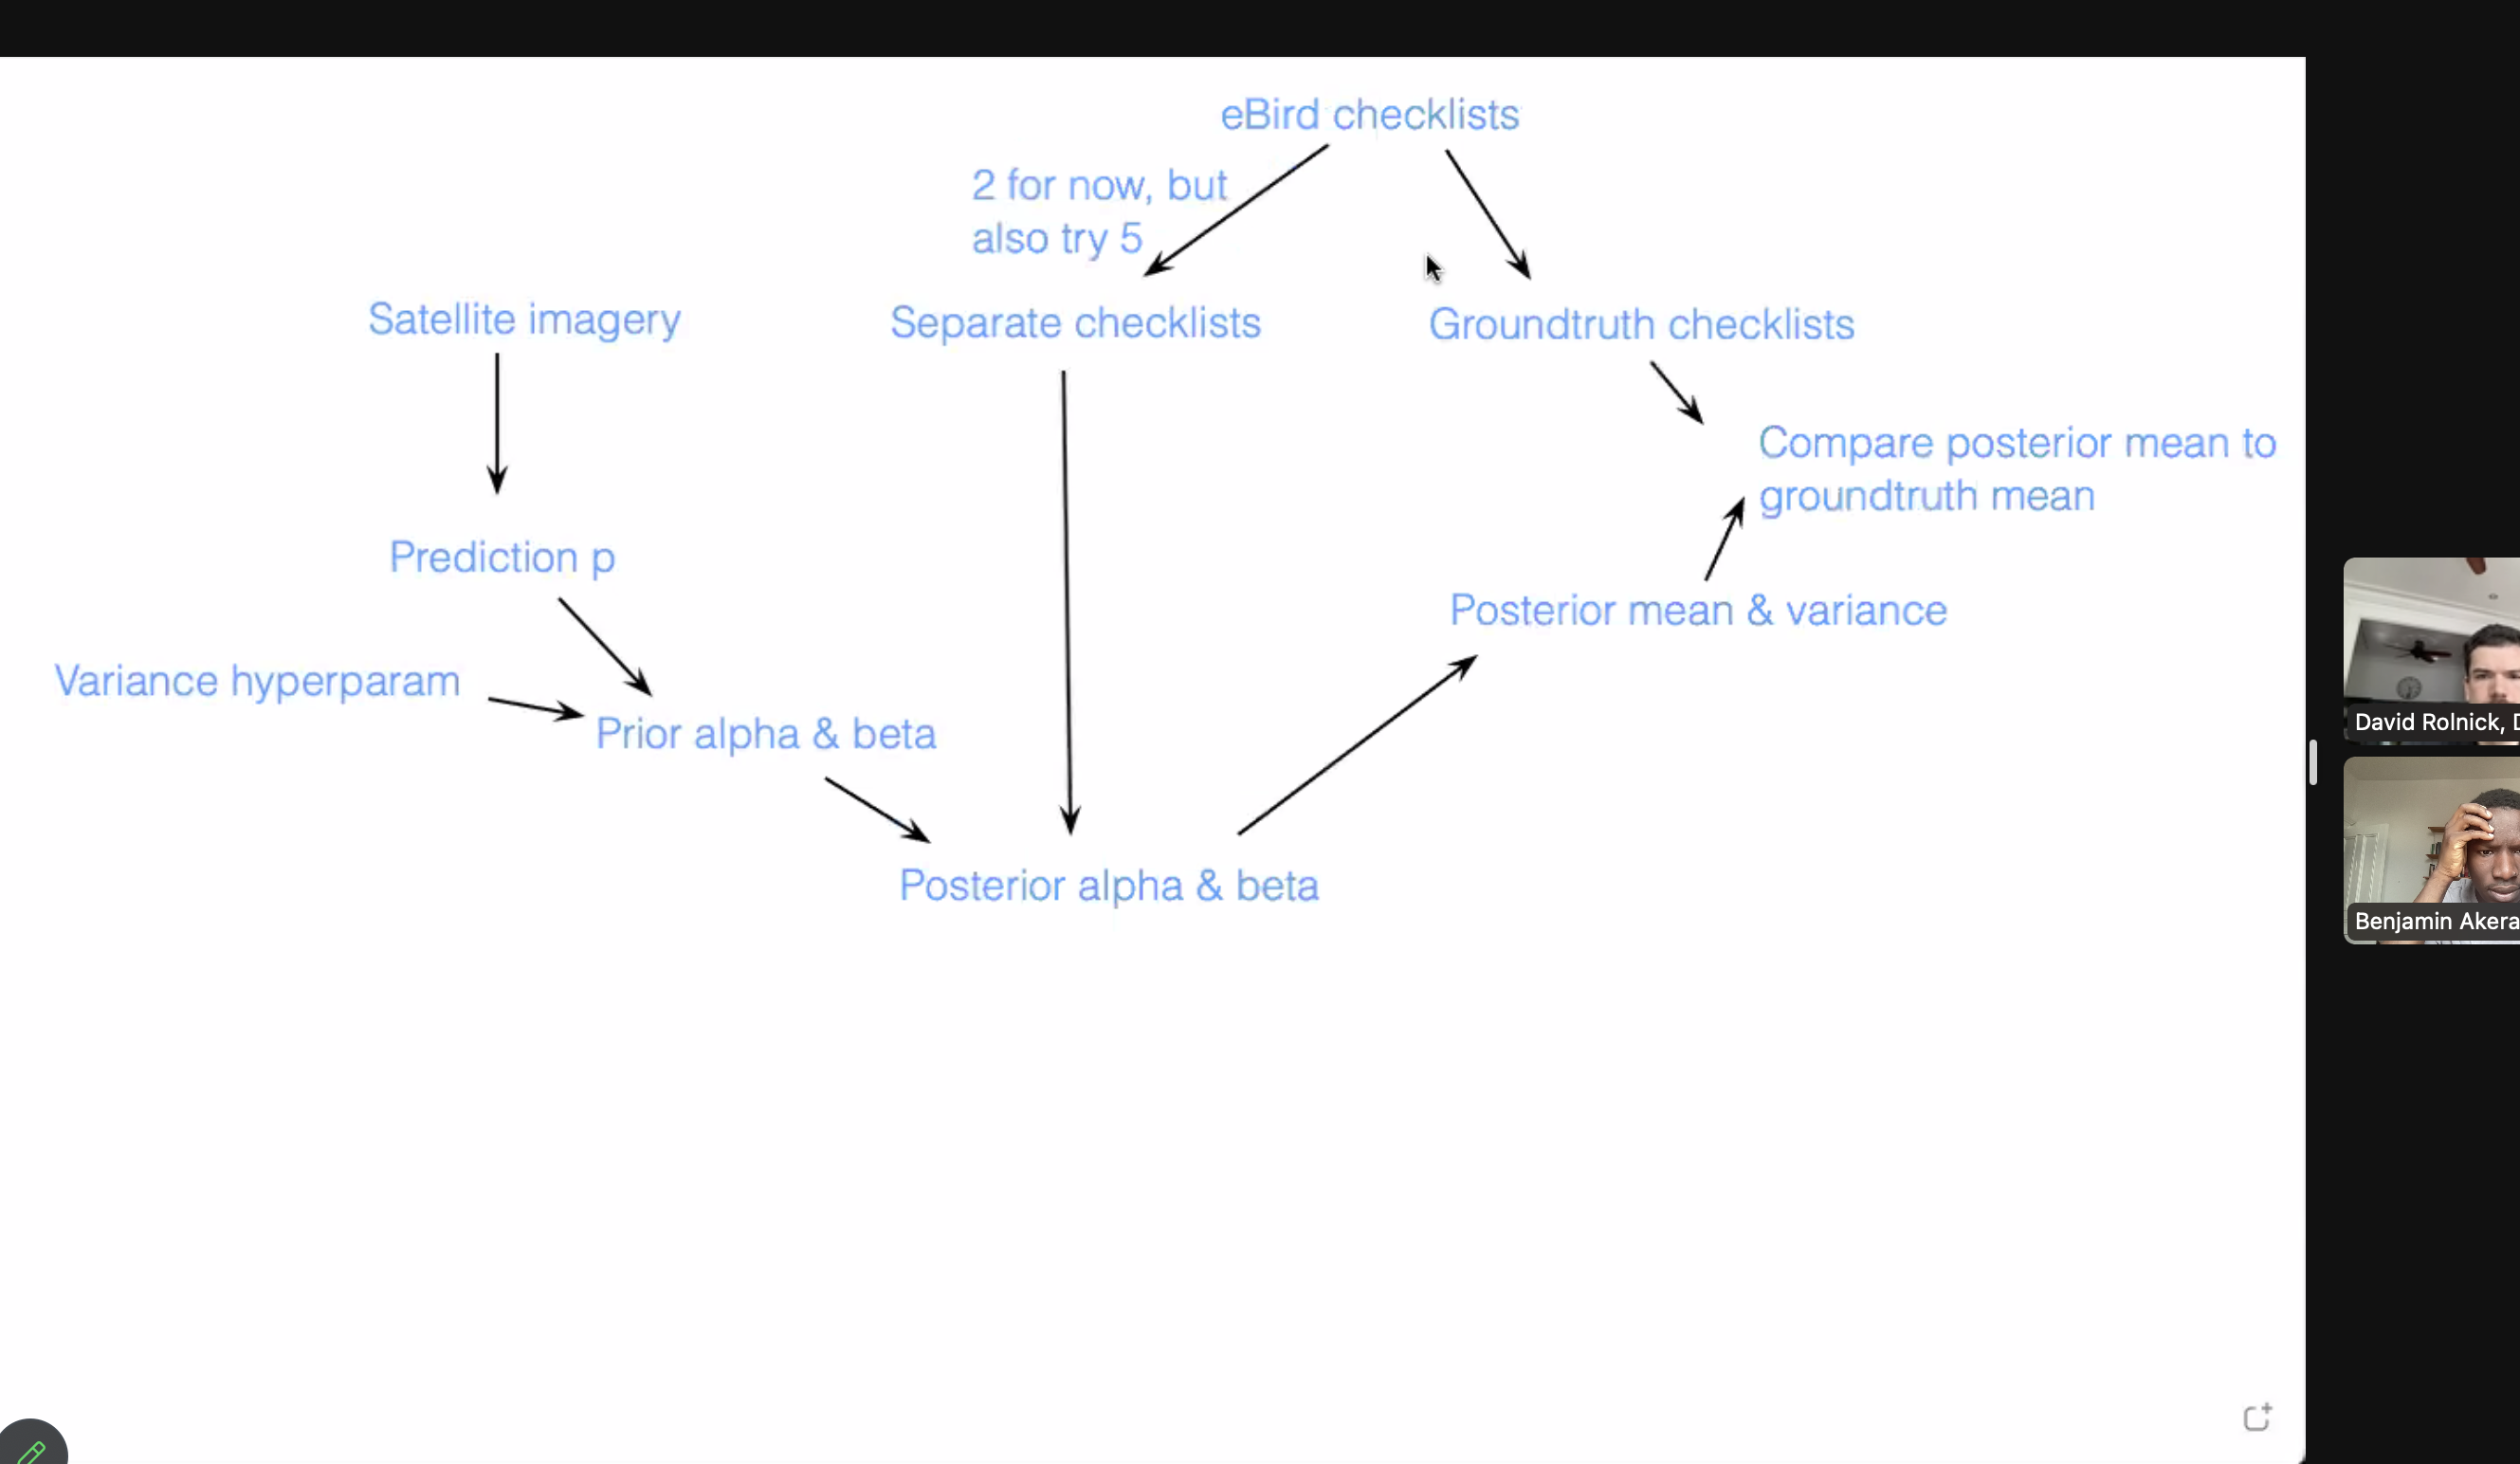

In [ ]:
with open('groundtruths_dict.pkl', 'rb') as fp:
    groundtruths_dict = pickle.load(fp)

with open('preds_dict.pkl', 'rb') as fp:
    preds_dict = pickle.load(fp)

In [ ]:
len(groundtruths_dict)

1672

In [ ]:
def get_prior_alpha_beta(preds, hyperparameter=0.5):
    """
    Calculates the prior alpha and beta for a beta distribution given the predictions `preds`.

    Parameters:
        preds (ndarray): An array of predicted encounter rates for all species at a hotspot.
        hyperparameter (float): A hyperparameter used to adjust the variance. Default is 1.

    Returns:
        tuple: A tuple containing the prior alpha and beta for the beta distribution.
    """
    # Calculate the mean and variance using the predictions and hyperparameter
    p = preds
    var = hyperparameter * p * (1 - p)

    # Calculate the alpha and beta using the mean and variance
    alpha_ = ((1 - p) / var - 1 / p) * p ** 2
    beta_ = alpha_ * (1 / p - 1)

    # Return the alpha and beta as a tuple
    return alpha_, beta_


def update_posterior_alpha_beta(prior_alpha, prior_beta, checklist):
    """
    This function updates the posterior alpha and beta parameters for the beta distribution
    using the complete checklists.

    Args:
        prior_alpha (numpy array): The prior alpha parameters for each species in the beta distribution.
        prior_beta (numpy array): The prior beta parameters for each species in the beta distribution.
        checklist (list): A list containing observations (0 or 1) of each species for a single checklist.

    Returns:
        numpy array: The updated posterior alpha parameters for each species in the beta distribution.
        numpy array: The updated posterior beta parameters for each species in the beta distribution.
    """
    # Convert the checklist to a numpy array and add it to the prior_alpha to update the posterior_alpha
    posterior_alpha = prior_alpha + np.array(checklist)

    # Subtract the checklist values from 1, convert to a numpy array, and add it to the prior_beta
    # to update the posterior_beta
    posterior_beta = prior_beta + (1 - np.array(checklist))

    #

    return posterior_alpha, posterior_beta


def get_posterior_mean_var(alpha, beta):
    """
    This function calculates the posterior mean and variance for each species in the beta distribution.

    Args:
        alpha (numpy array): The posterior alpha parameters for each species in the beta distribution.
        beta (numpy array): The posterior beta parameters for each species in the beta distribution.

    Returns:
        numpy array: The posterior mean for each species in the beta distribution.
        numpy array: The posterior variance for each species in the beta distribution.
    """
    # Calculate the posterior mean by dividing alpha by the sum of alpha and beta
    posterior_mean = alpha / (alpha + beta)

    # Calculate the posterior variance using the formula:
    # (alpha * beta) / ((alpha + beta)^2 * (alpha + beta + 1))
    posterior_var = (alpha * beta) / ((alpha + beta)**2 * (alpha + beta + 1))

    return posterior_mean, posterior_var


def get_groundtruth_mean(hotspot_data):
    """
    Calculates the mean of all the complete checklists in `hotspot_data`.

    Args:
        hotspot_data (dict): A dictionary containing information about a hotspot.

    Returns:
        ndarray: An array containing the mean values for each species in the checklists.
    """
    checklists = hotspot_data['checklists']
    num_checklists = len(checklists)
    sum_checklists = np.zeros(684)

    for checklist in checklists:
        sum_checklists += np.array(checklist['complete_checklist'])

    return sum_checklists / num_checklists


In [ ]:
# Create a dictionary of hotspots to sample, only including those with at least 10 checklists
hotspots_to_sample = {
    k: v for k, v in groundtruths_dict.items() if len(v["checklists"]) >= 10
}

# Initialize an empty dictionary to store the posterior distributions for each hotspot
updated_distributions = {}

# Iterate over each hotspot in the hotspots_to_sample dictionary
for hotspot_id, hotspot_data in hotspots_to_sample.items():
    # Get the predicted encounter rate for each species at the current hotspot
    p = preds_dict[hotspot_id]

    # Calculate the prior alpha and beta for the current hotspot using the predicted encounter rate and variance
    prior_alpha, prior_beta = get_prior_alpha_beta(p)

    # Iterate over each complete checklist for the current hotspot and update the posterior alpha and beta
    for i in range(10):
        checklist_data = hotspot_data["checklists"][i]["complete_checklist"]
        posterior_alpha, posterior_beta = update_posterior_alpha_beta(
            prior_alpha, prior_beta, checklist_data
        )

        # Set the posterior alpha and beta as the prior alpha and beta for the next iteration
        prior_alpha, prior_beta = posterior_alpha, posterior_beta

    # Calculate the posterior mean and variance for each species at the current hotspot
    posterior_mean, posterior_var = get_posterior_mean_var(
        posterior_alpha, posterior_beta
    )

    # Store the posterior mean and variance in the updated_distributions dictionary for the current hotspot
    updated_distributions[hotspot_id] = {
        "posterior_mean": posterior_mean,
        "posterior_var": posterior_var,
    }

In [ ]:
updated_distributions["L109215"]["posterior_mean"][0]

1.2907817347475197e-05

In [ ]:
preds_dict["L109215"][0]

0.00014198599

In [ ]:
comparison_results = {}

for hotspot_id, hotspot_data in hotspots_to_sample.items():
    groundtruth_mean = get_groundtruth_mean(hotspot_data)
    posterior_mean = updated_distributions[hotspot_id]['posterior_mean']

    mean_difference = posterior_mean - groundtruth_mean
    mean_absolute_error = np.mean(np.abs(mean_difference))

    comparison_results[hotspot_id] = {
        'groundtruth_mean': groundtruth_mean,
        'posterior_mean': posterior_mean,
        'mean_difference': mean_difference,
        'mean_absolute_error': mean_absolute_error
    }

In [ ]:
comparison_results["L109215"]["posterior_mean"][0]

1.2907817347475197e-05

In [ ]:
# Sample function call to get the comparison result for a specific hotspot
sample_hotspot_id = list(hotspots_to_sample.keys())[0]
sample_comparison_result = comparison_results[sample_hotspot_id]

In [ ]:
sample_comparison_result.keys()

dict_keys(['groundtruth_mean', 'posterior_mean', 'mean_difference', 'mean_absolute_error'])

In [ ]:
# updated_distributions.keys()

In [ ]:
def plot_comparison(hotspot_id: str,
                    comparison_result: dict,
                    num_species_to_plot: int = 20) -> None:
    """
    Plots a bar chart comparing the posterior mean and ground truth mean for a given hotspot.

    Args:
        hotspot_id (str): The ID of the hotspot being plotted.
        comparison_result (dict): A dictionary containing the ground truth and posterior means and variances.
        num_species_to_plot (int): The number of species to plot. Default is 20.

    Returns:
        None
    """
    groundtruth_mean = comparison_result['groundtruth_mean'][:num_species_to_plot]
    posterior_mean = comparison_result['posterior_mean'][:num_species_to_plot]
    species_indices = np.arange(num_species_to_plot)

    plt.figure(figsize=(12, 6))
    plt.bar(species_indices - 0.2, groundtruth_mean, width=0.4, label='Ground Truth Mean')
    plt.bar(species_indices + 0.2, posterior_mean, width=0.4, label='Posterior Mean')

    plt.xlabel('Species Index')
    plt.ylabel('Mean')
    plt.title(f'Comparison of Posterior Mean and Ground Truth Mean for Hotspot {hotspot_id}')
    plt.legend()

    plt.xticks(species_indices)
    plt.show()


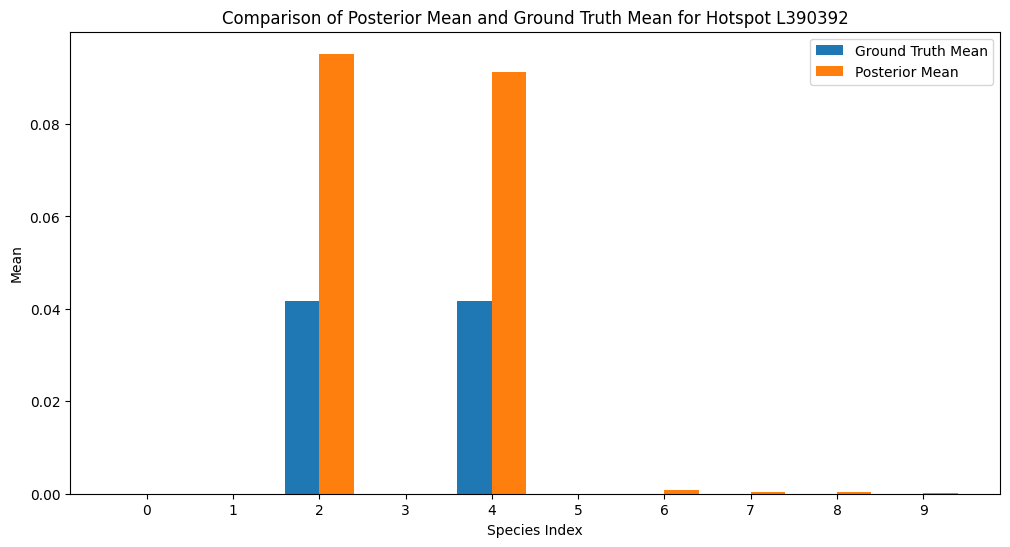

In [ ]:
# Example usage:
sample_hotspot_id = list(hotspots_to_sample.keys())[9]
sample_comparison_result = comparison_results[sample_hotspot_id]
plot_comparison(sample_hotspot_id, sample_comparison_result, num_species_to_plot=10)

In [ ]:
def plot_species_distribution(
    hotspot_id,
    comparison_result,
    num_species_to_plot=20):
    """
    Plots the ground truth mean and posterior mean of a hotspot's species distribution.

    Args:
        hotspot_id (str): The ID of the hotspot.
        comparison_result (dict): A dictionary containing the ground truth mean and posterior mean for each species.
        num_species_to_plot (int): The number of species to plot.

    Returns:
        None
    """
    groundtruth_mean = comparison_result['groundtruth_mean'][:num_species_to_plot]
    posterior_mean = comparison_result['posterior_mean'][:num_species_to_plot]
    species_indices = np.arange(num_species_to_plot)

    plt.figure(figsize=(12, 6))
    plt.plot(species_indices, groundtruth_mean, marker='o', label='Ground Truth Mean')
    plt.plot(species_indices, posterior_mean, marker='x', label='Posterior Mean')

    plt.xlabel('Species Index')
    plt.ylabel('Mean')
    plt.title(f'Species Distribution for Hotspot {hotspot_id}')
    plt.legend()

    plt.xticks(species_indices)
    plt.show()

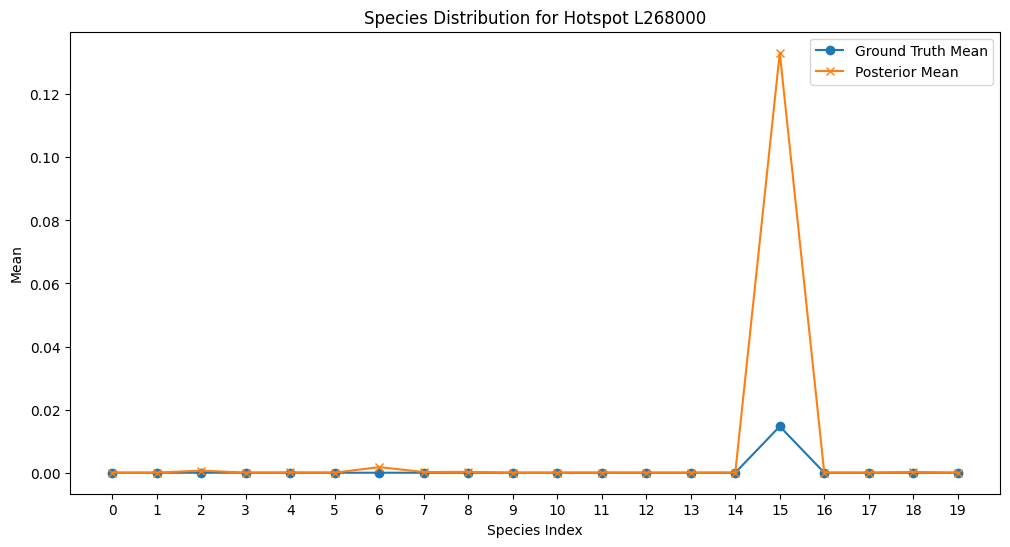

In [ ]:

# Example usage:
sample_hotspot_id = list(hotspots_to_sample.keys())[6]
sample_comparison_result = comparison_results[sample_hotspot_id]
plot_species_distribution(sample_hotspot_id, sample_comparison_result, num_species_to_plot=20)

In [ ]:
def plot_species_distribution_iteratively(
    hotspot_id,
    hotspot_data,
    preds,
    num_iterations=5,
    num_species_to_plot=20
):
    """
    Plot the species distribution of a given hotspot using an iterative approach.

    Args:
        hotspot_id (str): The ID of the hotspot to plot.
        hotspot_data (dict): The dictionary containing the groundtruth data for the hotspot.
        preds (array-like): The array of predicted values for the hotspot.
        num_iterations (int): The number of iterations to use in the iterative approach.
        num_species_to_plot (int): The number of species to plot.

    Returns:
        None
    """
    # Calculate the prior alpha and beta
    prior_alpha, prior_beta = get_prior_alpha_beta(preds)

    # Set up the figure for plotting
    plt.figure(figsize=(12, 6))
    species_indices = np.arange(num_species_to_plot)

    for i in range(1, num_iterations + 1):
        # Update the posterior distribution using i checklists
        posterior_alpha, posterior_beta = prior_alpha, prior_beta
        for checklist in hotspot_data["checklists"][:i]:
            posterior_alpha, posterior_beta = update_posterior_alpha_beta(
                posterior_alpha, posterior_beta, checklist["complete_checklist"]
            )

        # Calculate the posterior mean
        posterior_mean = posterior_alpha / (posterior_alpha + posterior_beta)
        posterior_mean = posterior_mean[:num_species_to_plot]

        # Plot the posterior mean
        plt.plot(
            species_indices, posterior_mean, marker="o", linestyle="-", label=f"Iteration {i}"
        )

    # Add labels and legend
    plt.xlabel("Species Index")
    plt.ylabel("Mean")
    plt.title(
        f"Species Distribution for Hotspot {hotspot_id} Over {num_iterations} Iterations"
    )
    plt.legend()
    plt.xticks(species_indices)
    plt.show()


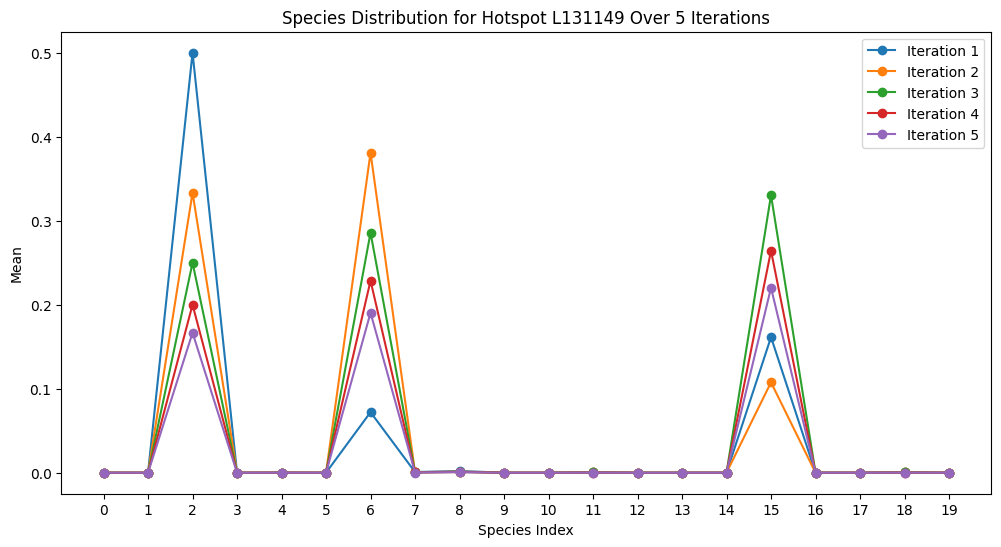

In [ ]:
# Example usage:
sample_hotspot_id = list(hotspots_to_sample.keys())[0]
sample_hotspot_data = hotspots_to_sample[sample_hotspot_id]
sample_preds = preds_dict[sample_hotspot_id]
plot_species_distribution_iteratively(sample_hotspot_id, sample_hotspot_data, sample_preds, num_iterations=5, num_species_to_plot=20)


## Calculate MSE


In [ ]:
def calculate_mse(groundtruths, posterior_mean):
    """
    Calculate the mean squared error between the posterior mean and the ground truth mean.

    Args:
        groundtruths (list): List of dictionaries containing ground truth information.
        posterior_mean (numpy.ndarray): Array containing the posterior mean of the predicted species encounter rate.

    Returns:
        float: Mean squared error between the posterior mean and the ground truth mean.
    """
    groundtruths_arrays = [np.array(checklist['complete_checklist']) for checklist in groundtruths]
    groundtruth_mean = np.mean(groundtruths_arrays, axis=0)
    mse = np.mean((posterior_mean - groundtruth_mean)**2)
    return mse


In [ ]:
def get_groundtruth_mean(checklists):
    """
    Calculate the mean of complete checklists for a given hotspot.

    Parameters:
        checklists (list): A list of checklists for a given hotspot.

    Returns:
        array: An array of mean values for each species at the hotspot.
    """
    num_checklists = len(checklists)
    sum_checklists = np.zeros(684)
    for checklist in checklists:
        sum_checklists += np.array(checklist['complete_checklist'])
    return sum_checklists / num_checklists


In [ ]:
def calculate_mae(checklists, posterior_mean):
    """
    Calculate the mean absolute error (MAE) between the ground truth and posterior means
    for a given hotspot.

    Parameters:
        checklists (list): A list of checklists for a given hotspot.
        posterior_mean (array): An array of posterior means for the species at the hotspot.

    Returns:
        float: The mean absolute error (MAE) between the ground truth and posterior means
        for a given hotspot.
    """
    groundtruth_mean = get_groundtruth_mean(checklists)
    mae = np.mean(np.abs(groundtruth_mean - posterior_mean))
    return mae

In [ ]:
def calculate_topk(groundtruth_checklists, posterior_mean, k=10):
    """
    Calculate the top-k accuracy between the ground truth means and posterior means.

    Parameters:
        groundtruth_checklists (list): A list of checklists for a given hotspot.
        posterior_mean (array): An array of posterior means for the species at the hotspot.
        k (int): The number of top elements to consider.

    Returns:
        float: The top-k accuracy.
    """
    groundtruth_mean = get_groundtruth_mean(groundtruth_checklists) # Assuming this function returns a list/array of means

    # Identify top-k indices for groundtruth and prediction
    topk_groundtruth_indices = np.argpartition(groundtruth_mean, -k)[-k:]
    topk_posterior_indices = np.argpartition(posterior_mean, -k)[-k:]

    # Calculate top-k accuracy
    topk_accuracy = len(np.intersect1d(topk_groundtruth_indices, topk_posterior_indices)) / k
    return topk_accuracy


In [ ]:
def plot_average_topk_vs_checklists(hotspots_to_sample,
                                    preds_dict,
                                    max_checklists=10,
                                    k=10):
    """
    Plot the average top-k accuracy as a function of
    the number of checklists used to update the posterior
    distribution for all hotspots.

    Parameters:
        hotspots_to_sample (dict): A dictionary containing hotspots
        and their respective complete checklists.
        Hotspots with less than 10 checklists will be excluded.

        preds_dict (dict): A dictionary containing hotspots
        and their respective predicted encounter rates.

        max_checklists (int): The maximum number of checklists to use
        for updating the posterior distribution.

        k (int): The number of top elements to consider.

    Returns:
        None
    """
    topk_list = []
    num_checklists_list = list(range(1, max_checklists + 1))

    for i in num_checklists_list:
        topk_sum = 0
        hotspot_count = 0
        for hotspot_id, hotspot_data in hotspots_to_sample.items():
            prior_alpha, prior_beta = get_prior_alpha_beta(preds_dict[hotspot_id])

            posterior_alpha, posterior_beta = prior_alpha, prior_beta
            for checklist in hotspot_data['checklists'][:i]:
                posterior_alpha, posterior_beta = update_posterior_alpha_beta(posterior_alpha, posterior_beta, checklist['complete_checklist'])

            # Calculate the posterior mean
            posterior_mean = posterior_alpha / (posterior_alpha + posterior_beta)

            # Calculate the top-k accuracy
            topk_accuracy = calculate_topk(hotspot_data["checklists"], posterior_mean, k)
            topk_sum += topk_accuracy
            hotspot_count += 1

        topk_list.append(topk_sum / hotspot_count)

    # Plot the average top-k accuracy as a function of the number of checklists used
    plt.figure(figsize=(8, 6))
    plt.plot(num_checklists_list, topk_list, marker='o', linestyle='-')
    plt.xlabel('Number of Checklists Used')
    plt.ylabel('Average Top-k Accuracy')
    plt.title(f'Average Top-{k} Accuracy vs Checklists for All {len(hotspots_to_sample)} Hotspots')
    plt.show()

    return topk_list


In [ ]:
def plot_average_mae_vs_checklists(hotspots_to_sample,
                                   preds_dict,
                                   max_checklists=10):
    """
    Plot the average mean absolute error (MAE) as a function of
    the number of checklists used to update the posterior
    distribution for all hotspots.

    Parameters:
        hotspots_to_sample (dict): A dictionary containing hotspots
        and their respective complete checklists.
        Hotspots with less than 10 checklists will be excluded.

        preds_dict (dict): A dictionary containing hotspots
        and their respective predicted encounter rates.

        max_checklists (int): The maximum number of checklists to use
        for updating the posterior distribution.

    Returns:
        None
    """

    mae_list = []
    num_checklists_list = list(range(1, max_checklists + 1))

    for i in num_checklists_list:
        mae_sum = 0
        hotspot_count = 0
        for hotspot_id, hotspot_data in hotspots_to_sample.items():
            prior_alpha, prior_beta = get_prior_alpha_beta(preds_dict[hotspot_id])

            posterior_alpha, posterior_beta = prior_alpha, prior_beta
            for checklist in hotspot_data['checklists'][:i]:
                posterior_alpha, posterior_beta = update_posterior_alpha_beta(posterior_alpha, posterior_beta, checklist['complete_checklist'])

            # Calculate the posterior mean
            posterior_mean = posterior_alpha / (posterior_alpha + posterior_beta)

            # Calculate the mean absolute error
            mae = calculate_mae(hotspot_data["checklists"], posterior_mean)
            mae_sum += mae
            hotspot_count += 1

        mae_list.append(mae_sum / hotspot_count)

    # Plot the average MAE as a function of the number of checklists used
    plt.figure(figsize=(8, 6))
    plt.plot(num_checklists_list, mae_list, marker='o', linestyle='-')
    plt.xlabel('Number of Checklists Used')
    plt.ylabel('Average Mean Absolute Error')
    plt.title(f'Average MAE vs Checklists for All {len(hotspots_to_sample)} Hotspots')
    plt.show()

    return mae_list


In [ ]:
def plot_mse_vs_checklists(hotspot_id, hotspot_data, preds, max_checklists=10):
    """
    Plot the Mean Squared Error (MSE) as a function of the number of checklists used to calculate the posterior distribution
    for a given hotspot, using the ground truth checklists and deep learning model predictions.

    Parameters:
    -----------
    hotspot_id: str
        The ID of the hotspot.
    hotspot_data: dict
        The ground truth data for the given hotspot.
    preds: numpy.ndarray
        The deep learning model predictions for the given hotspot.
    max_checklists: int, optional (default=10)
        The maximum number of checklists to use.

    Returns:
    --------
    None
    """
    # Calculate the prior alpha and beta
    prior_alpha, prior_beta = get_prior_alpha_beta(preds)

    mse_list = []
    num_checklists_list = list(range(1, max_checklists + 1))

    for i in num_checklists_list:
        posterior_alpha, posterior_beta = prior_alpha, prior_beta
        for checklist in hotspot_data['checklists'][:i]:
            posterior_alpha, posterior_beta = update_posterior_alpha_beta(posterior_alpha, posterior_beta, checklist['complete_checklist'])

        # Calculate the posterior mean
        posterior_mean = posterior_alpha / (posterior_alpha + posterior_beta)

        # Calculate the mean squared error
        mse = calculate_mse(hotspot_data["checklists"], posterior_mean)
        mse_list.append(mse)

    # Plot the MSE as a function of the number of checklists used
    plt.figure(figsize=(8, 6))
    plt.plot(num_checklists_list, mse_list, marker='o', linestyle='-')
    plt.xlabel('Number of Checklists Used')
    plt.ylabel('Mean Squared Error')
    plt.title(f'MSE vs Checklists for Hotspot {hotspot_id}')
    plt.show()

In [ ]:
# Example usage:
sample_hotspot_id = list(hotspots_to_sample.keys())[2]
sample_hotspot_data = hotspots_to_sample[sample_hotspot_id]
sample_preds = preds_dict[sample_hotspot_id]

In [ ]:
# sample_hotspot_data

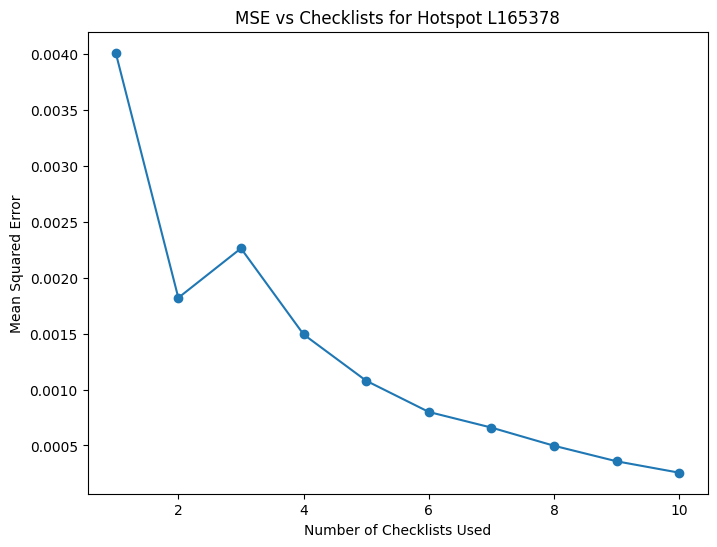

In [ ]:
plot_mse_vs_checklists(sample_hotspot_id, sample_hotspot_data, sample_preds, max_checklists=10)


In [ ]:
def plot_average_mse_vs_checklists(hotspots_to_sample,
                                   preds_dict,
                                   max_checklists=10):
    """
    Plot the average mean squared error (MSE) as a function of
    the number of checklists used to update the posterior
    distribution for all hotspots.

    Parameters:
        hotspots_to_sample (dict): A dictionary containing hotspots
        and their respective complete checklists.
        Hotspots with less than 10 checklists will be excluded.

        preds_dict (dict): A dictionary containing hotspots
        and their respective predicted encounter rates.

        max_checklists (int): The maximum number of checklists to use
        for updating the posterior distribution.

    Returns:
        None
    """

    mse_list = []
    num_checklists_list = list(range(1, max_checklists + 1))

    for i in num_checklists_list:
        mse_sum = 0
        hotspot_count = 0
        for hotspot_id, hotspot_data in hotspots_to_sample.items():
            prior_alpha, prior_beta = get_prior_alpha_beta(preds_dict[hotspot_id])

            posterior_alpha, posterior_beta = prior_alpha, prior_beta
            for checklist in hotspot_data['checklists'][:i]:
                posterior_alpha, posterior_beta = update_posterior_alpha_beta(posterior_alpha, posterior_beta, checklist['complete_checklist'])

            # Calculate the posterior mean
            posterior_mean = posterior_alpha / (posterior_alpha + posterior_beta)

            # Calculate the mean squared error
            mse = calculate_mse(hotspot_data["checklists"], posterior_mean)
            mse_sum += mse
            hotspot_count += 1

        mse_list.append(mse_sum / hotspot_count)

    # Plot the average MSE as a function of the number of checklists used
    plt.figure(figsize=(8, 6))
    plt.plot(num_checklists_list, mse_list, marker='o', linestyle='-')
    plt.xlabel('Number of Checklists Used')
    plt.ylabel('Average Mean Squared Error')
    plt.title(f'Average MSE vs Checklists for All {len(hotspots_to_sample)} Hotspots')
    plt.show()

    return mse_list

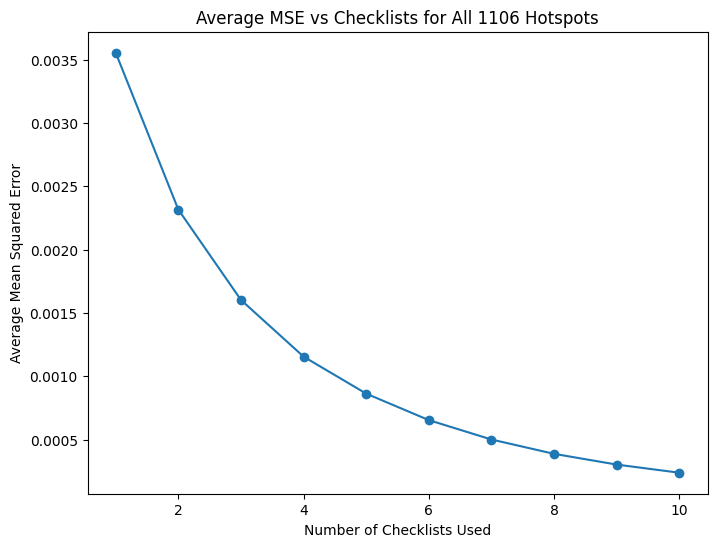

[0.0035558267712333153,
 0.002316401438661478,
 0.0016025374735148192,
 0.0011547115568531301,
 0.0008623695396055388,
 0.0006531606205652105,
 0.000499919453963762,
 0.00038669384092256804,
 0.0003018516720403391,
 0.00023753992131004718]

In [ ]:
# Example usage:
plot_average_mse_vs_checklists(hotspots_to_sample, preds_dict, max_checklists=10)


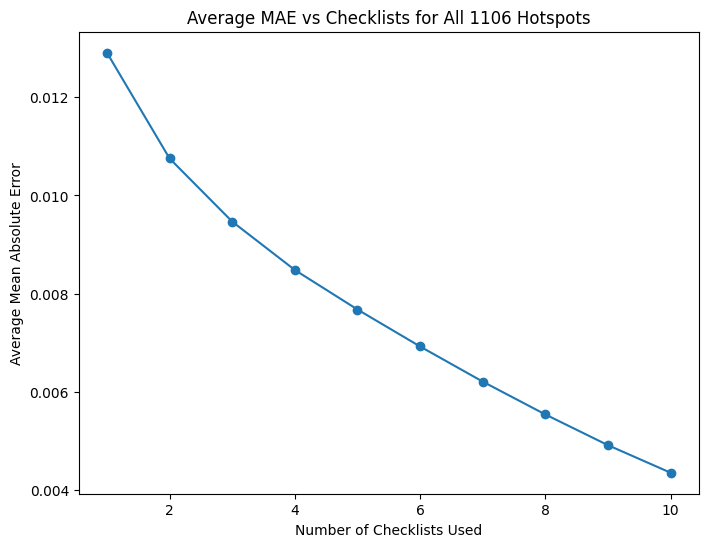

[0.012904318797263776,
 0.010752009081343177,
 0.009467458571612951,
 0.00848301505498857,
 0.0076787148353205424,
 0.0069263471080965025,
 0.0062116407148987895,
 0.005542998906273966,
 0.004917749942781428,
 0.004357369466356028]

In [ ]:
plot_average_mae_vs_checklists(hotspots_to_sample, preds_dict, max_checklists=10)


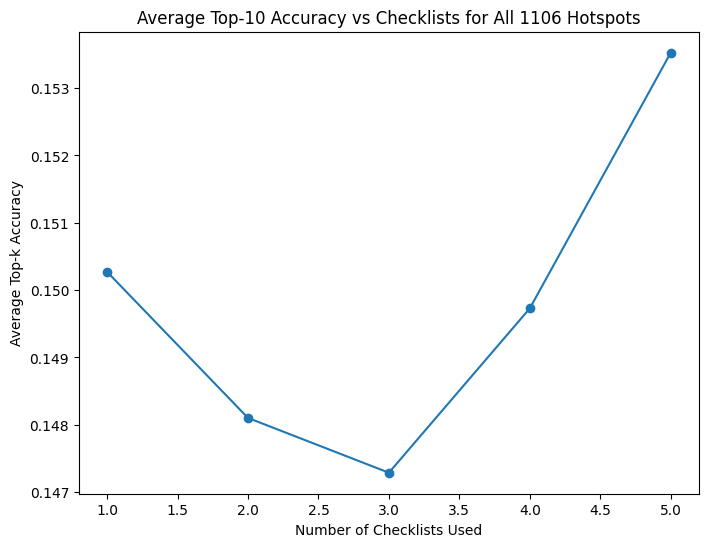

[0.15027124773960135,
 0.14810126582278424,
 0.14728752260397765,
 0.14972875226039695,
 0.15352622061482746]

In [ ]:
# plot_average_mse_vs_checklists(hotspots_to_sample, preds_dict, max_checklists=10)
plot_average_topk_vs_checklists(hotspots_to_sample,
                                    preds_dict,
                                    max_checklists=5,
                                    k=10)

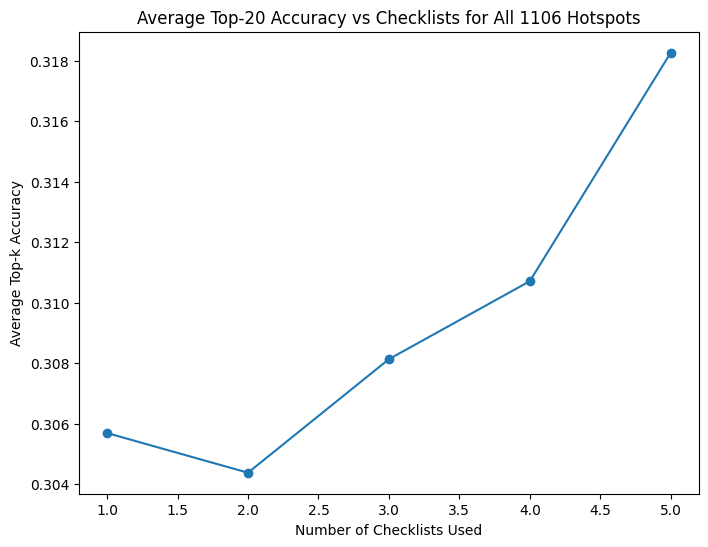

[0.3056962025316457,
 0.3043851717902348,
 0.3081374321880653,
 0.3107142857142854,
 0.3182640144665464]

In [ ]:
# plot_average_mse_vs_checklists(hotspots_to_sample, preds_dict, max_checklists=10)
plot_average_topk_vs_checklists(hotspots_to_sample,
                                    preds_dict,
                                    max_checklists=5,
                                    k=20)

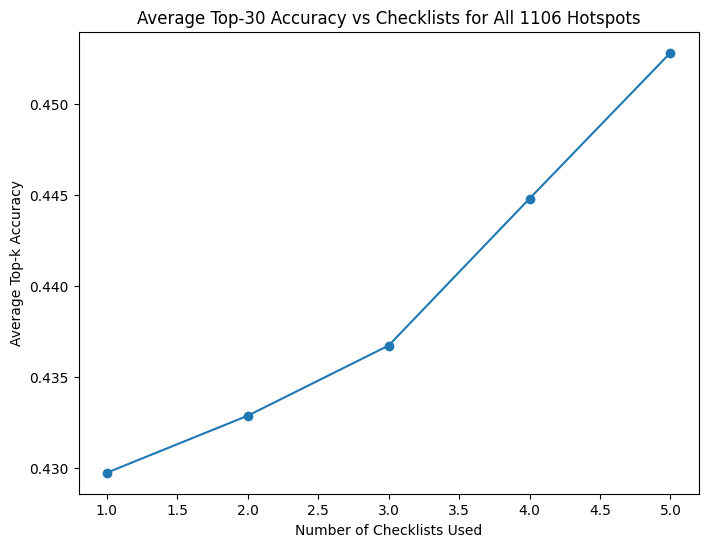

[0.429746835443038,
 0.43288125376732967,
 0.4367389993972272,
 0.44481615430982585,
 0.4528330319469556]

In [ ]:
# plot_average_mse_vs_checklists(hotspots_to_sample, preds_dict, max_checklists=10)
plot_average_topk_vs_checklists(hotspots_to_sample,
                                    preds_dict,
                                    max_checklists=5,
                                    k=30)

In [ ]:
# TODO:
# - Use a NN to output variance instead of a mean
# -

In [ ]:
## Compute Evaluation Metrics on Test Set
# top-k
# MAE
# MSE
#